# Dataset 1: Breast Cancer Wisconsin

This notebook presents a benchmark of three classification models on the
Breast Cancer Wisconsin dataset.

## Dataset description

The Breast Cancer Wisconsin dataset contains measurements of cell nuclei
computed from digitized images of fine needle aspirates of breast masses.

The task is a binary classification problem:
- 0 — malignant
- 1 — benign

In [22]:
%pip install numpy pandas scikit-learn matplotlib seaborn shap lime dice-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


-----

In [23]:
import numpy as np
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import dice_ml
from dice_ml import Dice

import seaborn as sns
import matplotlib.pyplot as plt
import shap

----

In [24]:
#LOAD AND NORMALIZE DATA
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_normalized = pd.DataFrame(
    X_normalized,
    columns=X.columns,
    index=X.index
)

X = X_normalized
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091
565,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635


In [25]:
print(
    f"Dataset shape: {X.shape}\n"
    f"Number of instances: {X.shape[0]}\n"
    f"Number of numerical features: {X.shape[1]}\n"
    f"Target variable: tumor type (benign vs malignant)\n"
    f"Class distribution:\n{y.value_counts()}"
)

Dataset shape: (569, 30)
Number of instances: 569
Number of numerical features: 30
Target variable: tumor type (benign vs malignant)
Class distribution:
target
1    357
0    212
Name: count, dtype: int64


In [26]:
## Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

----

# Benchmark

In [27]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

In [28]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy


# Find model with most accuracy - we will perform explanation on picked model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

best_model_name

'Logistic Regression'

----

# XAI


## Feature importance


In [29]:
coefficients = best_model.named_steps["model"].coef_[0]

feature_importance = (
    pd.Series(coefficients, index=X.columns)
    .sort_values(key=abs, ascending=False)
)

feature_importance.head(10)

worst texture          -1.250149
radius error           -1.070102
worst symmetry         -0.957045
worst concave points   -0.941888
area error             -0.941059
worst area             -0.925812
worst radius           -0.917480
worst concavity        -0.796758
worst perimeter        -0.721168
mean compactness        0.694230
dtype: float64

## SHAP

In [30]:
# SHAP setup
scaler = best_model.named_steps["scaler"]
lr_model = best_model.named_steps["model"]

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


explainer = shap.LinearExplainer(
    lr_model,
    X_train_scaled
)

shap_values = explainer.shap_values(X_test_scaled)


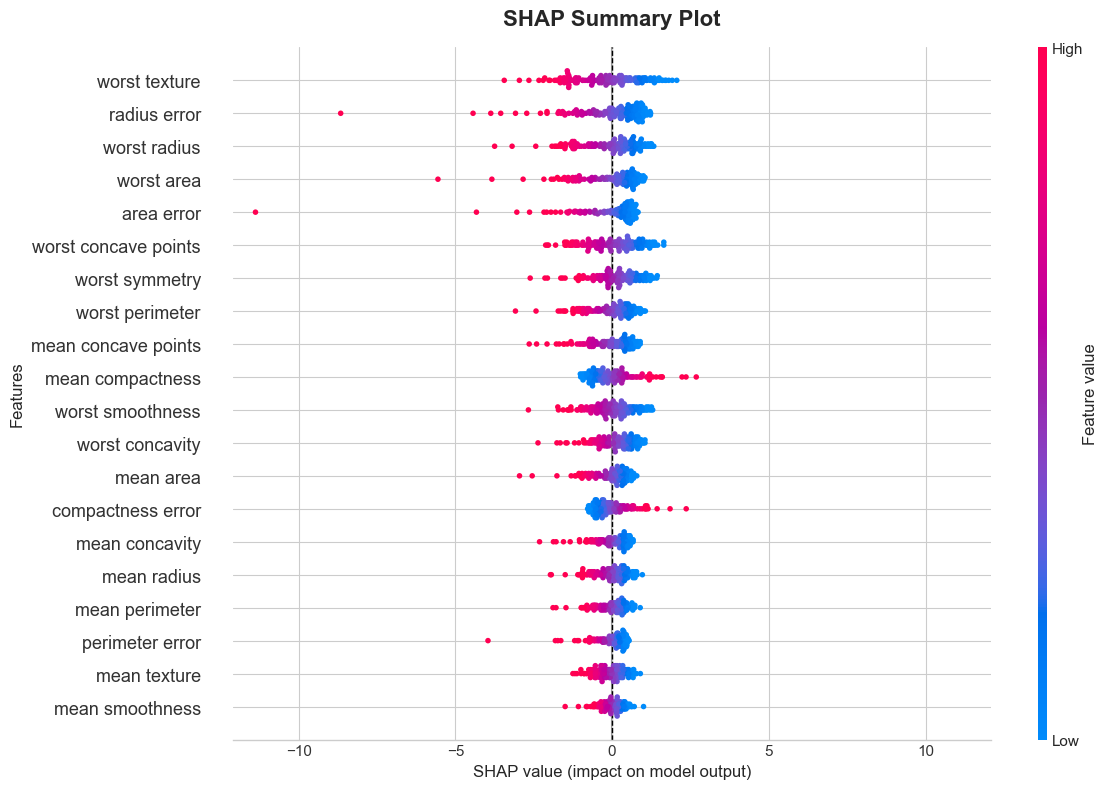

In [31]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),
    color_bar=True
)

ax = plt.gca()
ax.axvline(0, color="black", linestyle="--", linewidth=1)
max_abs = np.abs(ax.get_xlim()).max()
ax.set_xlim(-max_abs, max_abs)
plt.title(
    "SHAP Summary Plot",
    fontsize=16,
    weight="bold",
    pad=16
)

plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()

## LIME

In [32]:
#LIME setup

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["malignant", "benign"],
    discretize_continuous=True,
    mode="classification"
)

index = 0
instance = X_test.iloc[index]

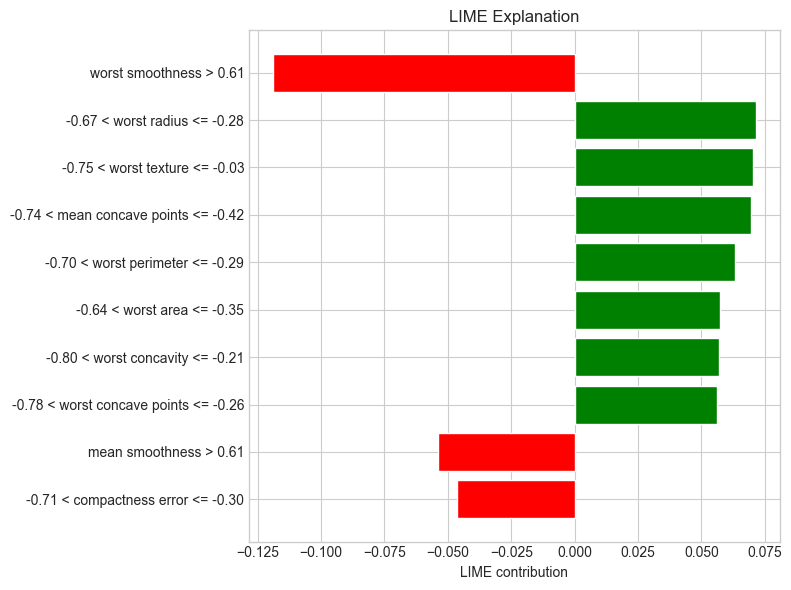

In [33]:
def predict_proba_pipeline(x):
    x_df = pd.DataFrame(x, columns=X.columns)
    return best_model.predict_proba(x_df)

lime_exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_pipeline,
    num_features=10
)

exp = lime_exp.as_list()

features = [x[0] for x in exp]
values = [x[1] for x in exp]

plt.figure(figsize=(8, 6))
colors = ["green" if v > 0 else "red" for v in values]

plt.barh(features, values, color=colors)
plt.xlabel("LIME contribution")
plt.title("LIME Explanation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Counterfactual Explanations (DiCE)

In [34]:
#DiCE setup

df = X.copy()
df["target"] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=X.columns.tolist(),
    outcome_name="target"
)

dice_model = dice_ml.Model(
    model=best_model,
    backend="sklearn",
    model_type="classifier"
)

dice = Dice(
    dice_data,
    dice_model,
    method="random"
)

query_instance = instance.to_frame().T

In [35]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

cf = dice.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class=0
)


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


In [36]:
cf_df = cf.cf_examples_list[0].final_cfs_df
original = query_instance.iloc[0]
diff = cf_df[X.columns] - original[X.columns]
diff_changed = diff.loc[:, (diff != 0).any(axis=0)]

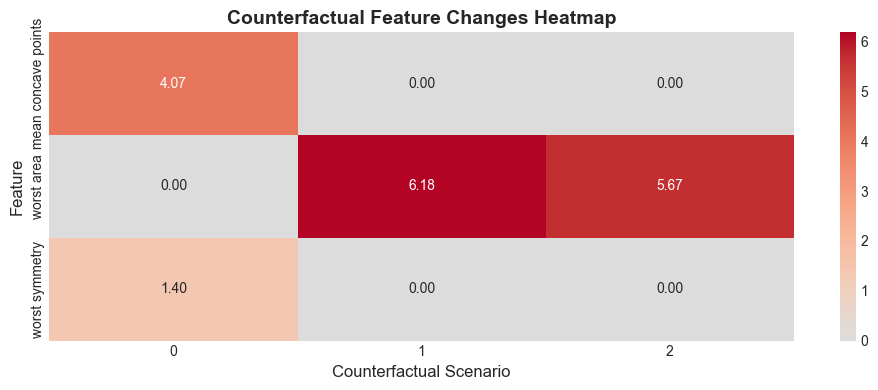

In [37]:
plt.figure(figsize=(10, 4))
sns.heatmap(
    diff_changed.T,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title("Counterfactual Feature Changes Heatmap", fontsize=14, weight="bold")
plt.xlabel("Counterfactual Scenario", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

----

## Evaluation

#### VALIDITY

In [38]:
desired_class = 0
cf_features = cf_df[X.columns]
cf_preds = best_model.predict(cf_features)
orig = query_instance.iloc[0][X.columns]
cf_X = cf_features
l1_distance = (cf_X - orig).abs().sum(axis=1)

In [39]:
validity = cf_preds == desired_class

validity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_preds))],
    "Predicted class": cf_preds,
    "Valid (prediction flipped)": validity
})

validity_df

,Counterfactual,Predicted class,Valid (prediction flipped)
0,CF_0,0,True
1,CF_1,0,True
2,CF_2,0,True


#### SPARSITY

In [40]:
sparsity = (cf_X != orig).sum(axis=1)

sparsity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(sparsity))],
    "Sparsity (number of features changed)": sparsity
})

sparsity_df


,Counterfactual,Sparsity (number of features changed)
0,CF_0,2
1,CF_1,1
2,CF_2,1


#### PROXIMITY


In [41]:
proximity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(l1_distance))],
    "Proximity (L1 distance)": l1_distance
})

proximity_df

,Counterfactual,Proximity (L1 distance)
0,CF_0,5.468624
1,CF_1,6.183269
2,CF_2,5.672167


#### PLAUSIBILITY

In [42]:
def plausible(cf_row, X):
    return ((cf_row >= X.min()) & (cf_row <= X.max())).all()

plausibility = cf_features.apply(lambda row: plausible(row, X), axis=1)

plausibility_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(plausibility))],
    "Plausible (within data range)": plausibility
})

plausibility_df

,Counterfactual,Plausible (within data range)
0,CF_0,True
1,CF_1,True
2,CF_2,True


----